Uncomment the following lines if running on Google Colaboratory. This will install versions of PyTorch and CuPy that work with our package, and then download the package files from the GitHub repo.

Restart the runtime when prompted to in the output of the cell.

In [1]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install cupy-cuda110
# !git clone https://github.com/BouazzaSE/NeuralXVA
# !mv NeuralXVA/* ./
# !rm -R NeuralXVA

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from learning.multiple_im_estimator import MultipleIMEstimatorPortfolio
from learning.misc import predict, predict_only_stats
from simulation.diffusion_engine import DiffusionEngine
import time
import torch
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = '100'

In [3]:
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=NumbaPerformanceWarning)

In [4]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True

In [6]:
# We need new predict functions here since the multi-alpha framework 
# requires calling the features_generator slightly differently

def predict_multialpha(estimator, alpha, num_coarse_steps, num_defs_per_path, num_paths, stop_at=0):
    features_gen = estimator._features_generator(alphas=alpha)
    predictor = estimator.predict(features_gen=features_gen, as_cuda_array=True, flatten=False)
    predicted_xva = np.empty((num_coarse_steps+1, num_defs_per_path*num_paths), dtype=np.float32)
    _v = predicted_xva.reshape(num_coarse_steps+1, num_defs_per_path, num_paths)
    for t in range(num_coarse_steps, stop_at-1, -1):
        next(predictor)
        _v[t] = predictor.send(t)
    return predicted_xva

def predict_only_stats_multialpha(estimator, alpha, stats, num_coarse_steps, recompute_at_zero=False):
    for stat in stats:
        assert isinstance(stat, str) or isinstance(stat, tuple)
        assert stat=='mean' or stat=='std' or ((len(stat)==2) and stat[0]=='quantile')
    device = estimator.device
    features_gen = estimator._features_generator(alphas=alpha)
    predictor = estimator.predict(features_gen=features_gen, as_cuda_array=True, flatten=False)
    predicted_xva_stats = {stat: np.empty(num_coarse_steps+1, dtype=np.float32) for stat in stats}
    end = 0 if recompute_at_zero else -1
    for t in range(num_coarse_steps, end, -1):
        next(predictor)
        _v = torch.as_tensor(predictor.send(t), dtype=torch.float32, device=device).view(-1)
        for stat, predicted_xva_stat in predicted_xva_stats.items():
            if stat == 'mean':
                _stat = _v.mean().item()
            elif stat == 'std':
                _stat = _v.std().item()
            else:
                _stat = _v.quantile(stat[1]).item()
            predicted_xva_stat[t] = _stat
    if recompute_at_zero:
        batch_gen = estimator._batch_generator(alphas=alpha, labels_as_cuda_tensors=True, train_mode=False)
        for t, _, labels_gen in batch_gen:
            if t == 0:
                if estimator._estimator.regr_type in ('mean', 'positive_mean'):
                    estimator.saved_states[0] = (False, batch_mean(labels_gen()).item())
                elif estimator._estimator.regr_type == 'quantile':
                    estimator.saved_states[0] = (False, torch.quantile(torch.cat(list(labels_gen()), dim=0), 1-alpha).item())
                else:
                    raise NotImplementedError
                for stat, predicted_xva_stat in predicted_xva_stats.items():
                    predicted_xva_stat[0] = 0 if stat=='std' else estimator.saved_states[0][1]
                break
    return predicted_xva_stats

## Simulation parameters

* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in \[1\]);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in \[1\]);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of \[1\]:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

**\[1\]** Abbas-Turki, L., S. Crépey, and B. Saadeddine (2022). Hierarchical simulation for learning with defaults. Pre-print available on https://perso.lpsm.paris/~crepey/papers/LEARNING_FROM_DEFAULTS.pdf.

In [7]:
num_coarse_steps = 100
dT = 0.1
num_fine_per_coarse = 25
dt = 0.004
num_paths = 2**19 # preferable to go for at least around 2**22 for better results
num_inner_paths = 1
num_defs_per_path = 1
num_rates = 10
num_spreads = 2
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.4, 0.03, num_rates)
rates_params['b'] = np.random.normal(0.03, 0.001, num_rates)
rates_params['sigma'] = np.abs(np.random.normal(0.0025, 0.00025, num_rates))
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.25, 0.025, num_rates-1))
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameters
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.5, 0.03, num_spreads)
spreads_params['b'] = np.random.normal(0.01, 0.001, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.0075, 0.00075, num_spreads))
initial_values[2*num_rates-1:] = 0.01

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0
vanilla_specs = np.empty(num_vanillas,
                         dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])

num_irs = 100
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 0.2  # Reset frequency
irs_specs['notional'] = 10000. * \
    ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5)))
     * np.random.choice(range(1, 11), num_irs))  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs))  # Swap rate, not needed, swaps are priced at par anyway
irs_specs['num_resets'] = np.random.randint(6, 51, num_irs, np.int32)  # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates-1, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs,
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

Next, we select the GPU. Should be `cuda:0` if there is only one GPU available. This is where both the simulation and the training/inference are going to be performed.

In [8]:
device = torch.device('cuda:0')

We then instantiate the diffusion engine and the multi-$\alpha$ IM estimator.

In [9]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device=device.index,
                                   no_nested_im=True, no_nested_cva=True)

# selector for previous swap resets, need the states at those dates because of how the small non-Markovianity in the swap prices

num_steps_per_reset = int((irs_specs['reset_freq'][0]+dt)/dT)
prev_reset_arr = (np.arange(num_coarse_steps+1)-1)//num_steps_per_reset*num_steps_per_reset

# IM learner

quantile_level_bounds = (0.0001, 0.15) # This needs always to be set, defines the bounds of the uniform dist over alpha

interpolation_nodes = torch.linspace(0.001, 0.15, 21, dtype=torch.float32) # Set to the multi-alpha III interpolation grid, or None if using the multi-alpha I or II methods
interpolation_nodes -= 0.5*(0.0001+0.15)
interpolation_nodes /= np.sqrt((0.15-0.0001)**2/12)

monotonicity_penalty = 0 # Only used if interpolation_nodes is set to None, defines the penalty coefficient for the derivative penalization term in multi-alpha I. If set to zero, then we have a multi-alpha II implementation.
im_estimator = MultipleIMEstimatorPortfolio(0, 'pay', quantile_level_bounds, interpolation_nodes, monotonicity_penalty, 
                                            1, prev_reset_arr, True, False, False, 
                                            diffusion_engine, device, 3, 6*num_rates, 
                                            (num_defs_per_path*num_paths)//32, 16, 0.01, 0, 
                                            reset_weights=False, linear=False, best_sol=True)

Successfully compiled all kernels.


## Training

Creating CUDA events in order to do some timings later:

In [10]:
with torch.cuda.device(device):
    _evt_start = torch.cuda.Event(enable_timing=True)
    _evt_stop = torch.cuda.Event(enable_timing=True)

We launch a first set of simulations in order to have paths on which to train on. This will simulate the risk factors and do all the pricings at the coarse time-steps.

In [11]:
_evt_start.record()
diffusion_engine.generate_batch(fused=True, set_irs_at_par=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Everything done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 42584.511 ms
Everything done in 45260.621 ms


We create a generator for the features and tell it to keep the data in CUDA memory and implicitly copy when assigning to Numpy arrays, and then we launch the training for the default indicators version.

In [12]:
print('Training...', end='')
_evt_start.record()
im_estimator.train(labels_as_cuda_tensors=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Training...done in 243.01 secs


At this point, a Neural Network estimator has been trained and the weights for any time-step `i` have been stored in the `.saved_states[i]`, *ie* if one wants to look at the parameters at time-step 20:

In [13]:
im_estimator.saved_states[20]

(True,
 (OrderedDict([('x_mean',
                tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0.]], device='cuda:0')),
               ('x_std',
                tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')),
               ('y_mean', tensor([[0.]], device='cuda:0')),
               ('y_std', tensor([[1.]], device='cuda:0')),
               ('interpolation_nodes',
                tensor([-1.7113, -1.5391, -1.3669, -1.1948, -1.0226, -0.8504, -0.6783, -0.5061,
                        -0.3339, -0.1618,  0.0104,  0.1826,  0.3547,  0.5269,  0.6991,  0.8712,
                         1.0434,  1.2156,  1.3877,  1.5599,  1.7321], device='cuda:0')),
               ('interpolation_nodes_delta',
                tensor([0.1722, 0.1722, 0.1722, 0.1722, 0.1722, 0.1722, 0.17

Notice the first component is `True`. When it instead is `False`, it simply means that no learning has been done, because either it was the first time-step (simple unconditional quantile) or a time-step at which the labels have numerically zero variance (in which case the conditional quantile is simply the unconditional average).

## Inference

Now we would like to output IM values for different values of $\alpha$ from our trained learner. We first launch a new set of paths. This time, we tell the diffusion engine to run a Nested Monte Carlo simulation at time-steps 30, 60 and 90 in order to get a NMC estimator of the IM at those time-steps, which will be used as a benchmark against which we will compare the learners below.

If you want a Nested MC estimator, just keep in mind that you'd need to relaunch the nested simulations for different values of alpha (keyword param `alpha` in the `generate_batch` method of the DiffusionEngine instance) and at each dump you save/dump the contents of the `nested_im_by_cpty` array if you intend to perform simultaneous comparisons pour many values of alpha.

The code for the nested MC simulations below is commented out by default as it is slow.

We will first recreate our DiffusionEngine in order to reduce the number of outer paths to allow for enough inner paths. We need less outer paths than previously because now we're done learning. We also correspondingly update our IMEstimator because the sample size changed.

In [14]:
import gc

old_num_paths = num_paths
num_paths = 2**14 # 2**15
num_inner_paths = 512 # 1024
num_defs_per_path = 1

diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device=device.index,
                                   no_nested_im=False, no_nested_cva=True)

im_estimator.diffusion_engine = diffusion_engine
im_estimator._estimator.num_samples = num_defs_per_path*num_paths
im_estimator._estimator.batch_size = im_estimator.batch_size = (num_defs_per_path*num_paths)//32

gc.collect()

Successfully compiled all kernels.


212

In [15]:
_evt_start.record()
for _ in range((old_num_paths+num_paths-1)//num_paths):
    diffusion_engine.generate_batch(fused=True, set_irs_at_par=True)
_evt_stop.record()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

cuda_diffuse_and_price elapsed time: 1704.861 ms
cuda_diffuse_and_price elapsed time: 1701.833 ms
cuda_diffuse_and_price elapsed time: 1744.631 ms
cuda_diffuse_and_price elapsed time: 1739.795 ms
cuda_diffuse_and_price elapsed time: 1752.109 ms
cuda_diffuse_and_price elapsed time: 1783.975 ms
cuda_diffuse_and_price elapsed time: 1799.252 ms
cuda_diffuse_and_price elapsed time: 1835.79 ms
cuda_diffuse_and_price elapsed time: 1789.523 ms
cuda_diffuse_and_price elapsed time: 1822.253 ms
cuda_diffuse_and_price elapsed time: 1978.546 ms
cuda_diffuse_and_price elapsed time: 1929.35 ms
cuda_diffuse_and_price elapsed time: 1956.295 ms
cuda_diffuse_and_price elapsed time: 1922.549 ms
cuda_diffuse_and_price elapsed time: 1893.554 ms
cuda_diffuse_and_price elapsed time: 1853.077 ms
cuda_diffuse_and_price elapsed time: 1849.615 ms
cuda_diffuse_and_price elapsed time: 1853.216 ms
cuda_diffuse_and_price elapsed time: 1854.939 ms
cuda_diffuse_and_price elapsed time: 1852.666 ms
cuda_diffuse_and_price

In [16]:
# uncomment if you want to compute a Nested MC estimator

# nested_timesteps = [30, 60, 90]
# diffusion_engine.generate_batch(fused=True, set_irs_at_par=True, nested_im_at=nested_timesteps, alpha=alpha, im_window=1)

In order to perform inference, one normally needs a *predictor* (via `.predict`) and then iterate over the time-steps and call it as needed to generate the predictions. Note that the predictor will also need a features generator where we fix $\alpha$ at every inference run. However, our helper function `predict_multialpha` defined above makes things much easier.

In [17]:
print('Performing inference...', end='')
inference_alphas = (0.001, 0.005, 0.01, 0.02, 0.05, 0.1)
_evt_start.record()
predicted_im_out = {
    alpha: predict_multialpha(im_estimator, alpha, num_coarse_steps, 1, num_paths)
    for alpha in inference_alphas
}
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)/1000
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Performing inference...done in 12.27 secs


Now we plot a few statistics of the learned IM along the time axis (unconditional mean & a few percentiles) and also plot the same statistics for our NMC estimator.

If we want only statistics and not individual realizations, then the following is enough and launching `predict` as we did previously is not necessary. The following will not be faster but it will use less memory, as storing all realizations for all time steps is not necessary and only statistics are stored at each time step.

In [18]:
stats = ('mean', ('quantile', 0.99), ('quantile', 0.975), ('quantile', 0.025), ('quantile', 0.01))

predicted_im_stats = {
    alpha: predict_only_stats_multialpha(im_estimator, alpha, stats, num_coarse_steps, recompute_at_zero=True)
    for alpha in inference_alphas
}

# uncomment the following lines if you're including the Nested MC estimator
# nested_im_stats = {
#     'mean': diffusion_engine.nested_im_by_cpty[nested_timesteps, 0].mean(axis=1),
#     ('quantile', 0.975): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 97.5, axis=1),
#     ('quantile', 0.025): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 2.5, axis=1),
#     ('quantile', 0.99): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 99, axis=1),
#     ('quantile', 0.01): np.percentile(diffusion_engine.nested_im_by_cpty[nested_timesteps, 0], 1, axis=1)
# }

Below are some plots of the learned IMs. Notice the **non-crossing** of the different term structures corresponding to different values of $\alpha$.

## Term structures of the mean of the learned conditional IM for different values of $\alpha$

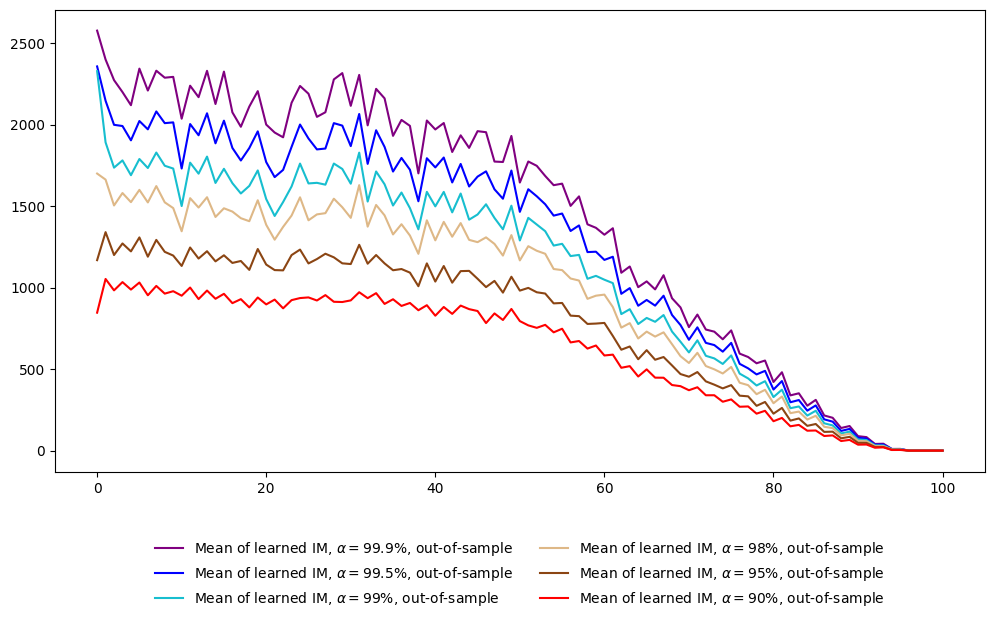

In [19]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats[0.001]['mean'], label=r'Mean of learned IM, $\alpha=99.9\%$, out-of-sample', color='purple')
plt.plot(predicted_im_stats[0.005]['mean'], label=r'Mean of learned IM, $\alpha=99.5\%$, out-of-sample', color='blue')
plt.plot(predicted_im_stats[0.01]['mean'], label=r'Mean of learned IM, $\alpha=99\%$, out-of-sample', color='tab:cyan')
plt.plot(predicted_im_stats[0.02]['mean'], label=r'Mean of learned IM, $\alpha=98\%$, out-of-sample', color='burlywood')
plt.plot(predicted_im_stats[0.05]['mean'], label=r'Mean of learned IM, $\alpha=95\%$, out-of-sample', color='saddlebrown')
plt.plot(predicted_im_stats[0.1]['mean'], label=r'Mean of learned IM, $\alpha=90\%$, out-of-sample', color='red')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

## Term structures of the 99% and 1% percentiles of the learned conditional IM for different values of $\alpha$

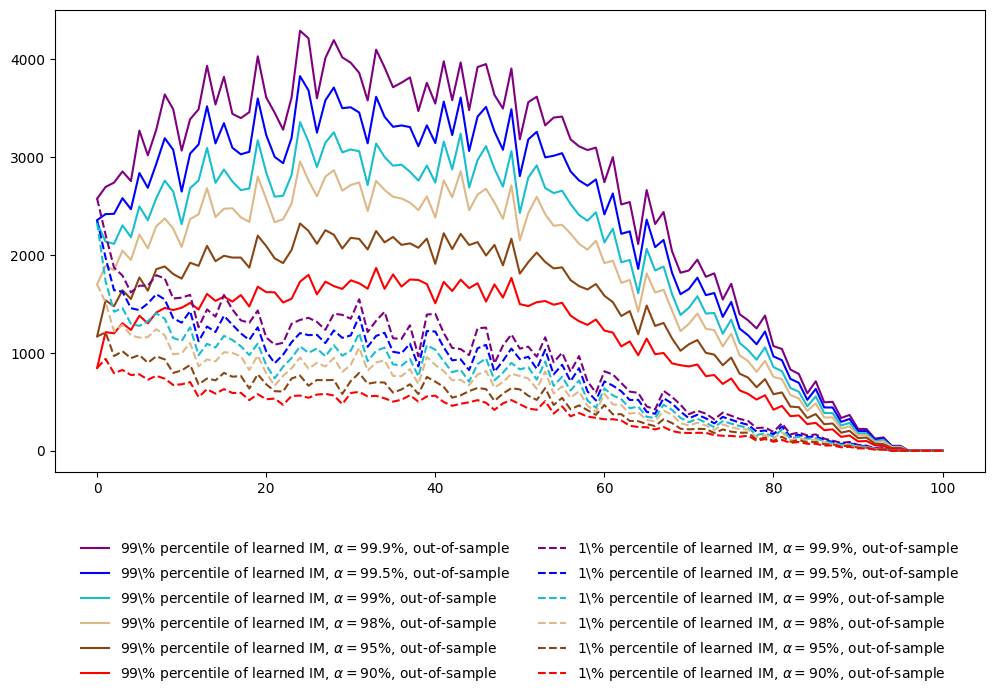

In [24]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats[0.001]['quantile', 0.99], label=r'99\% percentile of learned IM, $\alpha=99.9\%$, out-of-sample', color='purple')
plt.plot(predicted_im_stats[0.005]['quantile', 0.99], label=r'99\% percentile of learned IM, $\alpha=99.5\%$, out-of-sample', color='blue')
plt.plot(predicted_im_stats[0.01]['quantile', 0.99], label=r'99\% percentile of learned IM, $\alpha=99\%$, out-of-sample', color='tab:cyan')
plt.plot(predicted_im_stats[0.02]['quantile', 0.99], label=r'99\% percentile of learned IM, $\alpha=98\%$, out-of-sample', color='burlywood')
plt.plot(predicted_im_stats[0.05]['quantile', 0.99], label=r'99\% percentile of learned IM, $\alpha=95\%$, out-of-sample', color='saddlebrown')
plt.plot(predicted_im_stats[0.1]['quantile', 0.99], label=r'99\% percentile of learned IM, $\alpha=90\%$, out-of-sample', color='red')

plt.plot(predicted_im_stats[0.001]['quantile', 0.01], label=r'1\% percentile of learned IM, $\alpha=99.9\%$, out-of-sample', color='purple', linestyle='dashed')
plt.plot(predicted_im_stats[0.005]['quantile', 0.01], label=r'1\% percentile of learned IM, $\alpha=99.5\%$, out-of-sample', color='blue', linestyle='dashed')
plt.plot(predicted_im_stats[0.01]['quantile', 0.01], label=r'1\% percentile of learned IM, $\alpha=99\%$, out-of-sample', color='tab:cyan', linestyle='dashed')
plt.plot(predicted_im_stats[0.02]['quantile', 0.01], label=r'1\% percentile of learned IM, $\alpha=98\%$, out-of-sample', color='burlywood', linestyle='dashed')
plt.plot(predicted_im_stats[0.05]['quantile', 0.01], label=r'1\% percentile of learned IM, $\alpha=95\%$, out-of-sample', color='saddlebrown', linestyle='dashed')
plt.plot(predicted_im_stats[0.1]['quantile', 0.01], label=r'1\% percentile of learned IM, $\alpha=90\%$, out-of-sample', color='red', linestyle='dashed')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

## Term structures of the 97.5% and 2.5% percentiles of the learned conditional IM for different values of $\alpha$

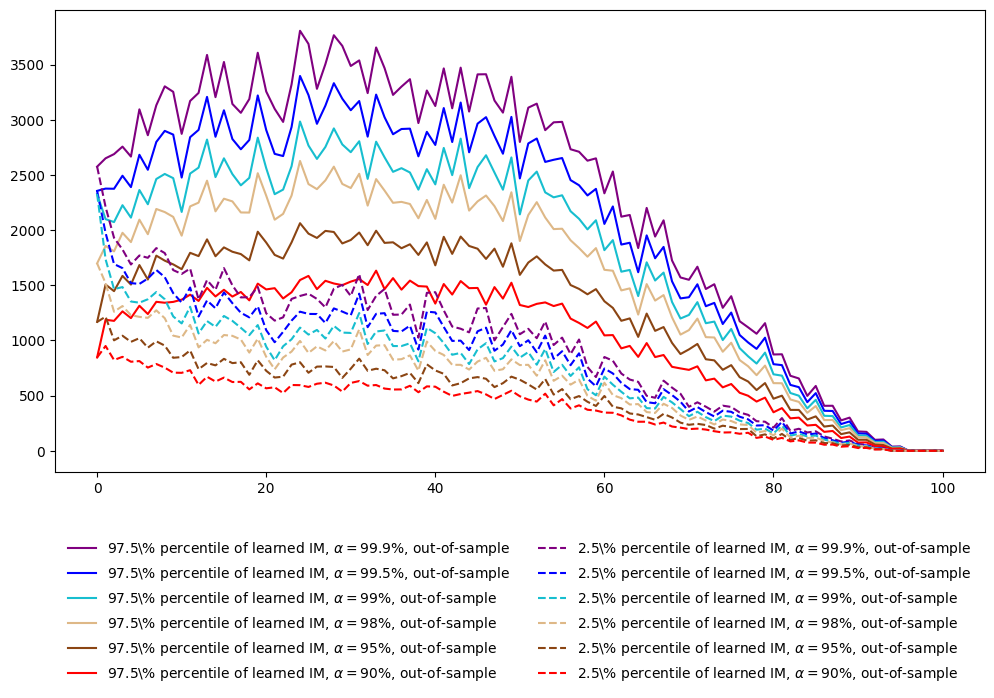

In [25]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats[0.001]['quantile', 0.975], label=r'97.5\% percentile of learned IM, $\alpha=99.9\%$, out-of-sample', color='purple')
plt.plot(predicted_im_stats[0.005]['quantile', 0.975], label=r'97.5\% percentile of learned IM, $\alpha=99.5\%$, out-of-sample', color='blue')
plt.plot(predicted_im_stats[0.01]['quantile', 0.975], label=r'97.5\% percentile of learned IM, $\alpha=99\%$, out-of-sample', color='tab:cyan')
plt.plot(predicted_im_stats[0.02]['quantile', 0.975], label=r'97.5\% percentile of learned IM, $\alpha=98\%$, out-of-sample', color='burlywood')
plt.plot(predicted_im_stats[0.05]['quantile', 0.975], label=r'97.5\% percentile of learned IM, $\alpha=95\%$, out-of-sample', color='saddlebrown')
plt.plot(predicted_im_stats[0.1]['quantile', 0.975], label=r'97.5\% percentile of learned IM, $\alpha=90\%$, out-of-sample', color='red')

plt.plot(predicted_im_stats[0.001]['quantile', 0.025], label=r'2.5\% percentile of learned IM, $\alpha=99.9\%$, out-of-sample', color='purple', linestyle='dashed')
plt.plot(predicted_im_stats[0.005]['quantile', 0.025], label=r'2.5\% percentile of learned IM, $\alpha=99.5\%$, out-of-sample', color='blue', linestyle='dashed')
plt.plot(predicted_im_stats[0.01]['quantile', 0.025], label=r'2.5\% percentile of learned IM, $\alpha=99\%$, out-of-sample', color='tab:cyan', linestyle='dashed')
plt.plot(predicted_im_stats[0.02]['quantile', 0.025], label=r'2.5\% percentile of learned IM, $\alpha=98\%$, out-of-sample', color='burlywood', linestyle='dashed')
plt.plot(predicted_im_stats[0.05]['quantile', 0.025], label=r'2.5\% percentile of learned IM, $\alpha=95\%$, out-of-sample', color='saddlebrown', linestyle='dashed')
plt.plot(predicted_im_stats[0.1]['quantile', 0.025], label=r'2.5\% percentile of learned IM, $\alpha=90\%$, out-of-sample', color='red', linestyle='dashed')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

## Plotting all statistics together for $\alpha=99\%$

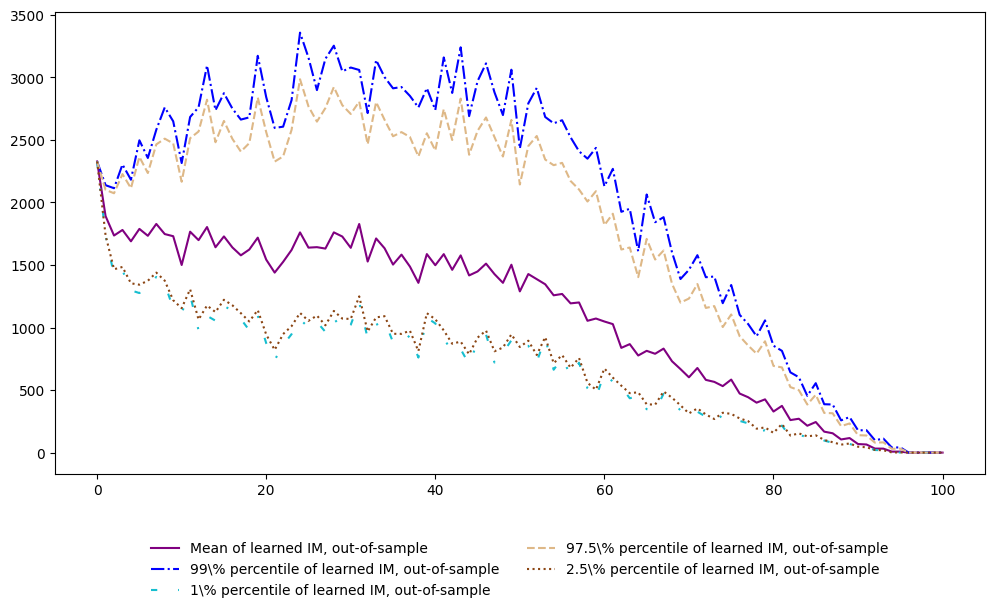

In [26]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats[0.01]['mean'], label='Mean of learned IM, out-of-sample', color='purple')
plt.plot(predicted_im_stats[0.01]['quantile', 0.99], label=r'99\% percentile of learned IM, out-of-sample', color='blue', linestyle='dashdot')
plt.plot(predicted_im_stats[0.01]['quantile', 0.01], label=r'1\% percentile of learned IM, out-of-sample', color='tab:cyan', linestyle=(0, (3, 10, 1, 10)))
plt.plot(predicted_im_stats[0.01]['quantile', 0.975], label=r'97.5\% percentile of learned IM, out-of-sample', color='burlywood', linestyle='dashed')
plt.plot(predicted_im_stats[0.01]['quantile', 0.025], label=r'2.5\% percentile of learned IM, out-of-sample', color='saddlebrown', linestyle='dotted')

# uncomment the following lines if you're including the Nested MC estimator in the plot
# plt.plot(nested_timesteps, nested_im_stats['mean'], marker='s', linestyle='None', label='Mean of Nested Monte-Carlo IM, out-of-sample', color='black')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.975], marker='^', linestyle='None', label=r'97.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='orange')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.025], marker='v', linestyle='None', label=r'2.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='gray')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.99], marker='x', linestyle='None', label=r'99\% percentile of Nested Monte-Carlo IM, out-of-sample', color='red')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.01], marker='+', linestyle='None', label=r'1\% percentile of Nested Monte-Carlo IM, out-of-sample', color='green')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

## Plotting all statistics together for $\alpha=98\%$

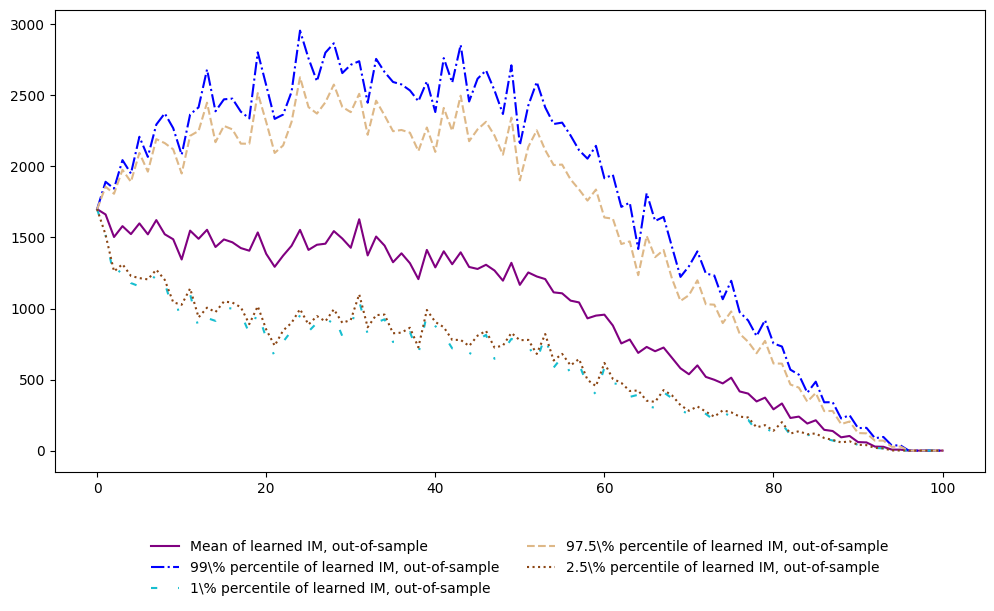

In [22]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats[0.02]['mean'], label='Mean of learned IM, out-of-sample', color='purple')
plt.plot(predicted_im_stats[0.02]['quantile', 0.99], label=r'99\% percentile of learned IM, out-of-sample', color='blue', linestyle='dashdot')
plt.plot(predicted_im_stats[0.02]['quantile', 0.01], label=r'1\% percentile of learned IM, out-of-sample', color='tab:cyan', linestyle=(0, (3, 10, 1, 10)))
plt.plot(predicted_im_stats[0.02]['quantile', 0.975], label=r'97.5\% percentile of learned IM, out-of-sample', color='burlywood', linestyle='dashed')
plt.plot(predicted_im_stats[0.02]['quantile', 0.025], label=r'2.5\% percentile of learned IM, out-of-sample', color='saddlebrown', linestyle='dotted')

# uncomment the following lines if you're including the Nested MC estimator in the plot
# plt.plot(nested_timesteps, nested_im_stats['mean'], marker='s', linestyle='None', label='Mean of Nested Monte-Carlo IM, out-of-sample', color='black')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.975], marker='^', linestyle='None', label=r'97.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='orange')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.025], marker='v', linestyle='None', label=r'2.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='gray')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.99], marker='x', linestyle='None', label=r'99\% percentile of Nested Monte-Carlo IM, out-of-sample', color='red')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.01], marker='+', linestyle='None', label=r'1\% percentile of Nested Monte-Carlo IM, out-of-sample', color='green')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);

## Plotting all statistics together for $\alpha=95\%$

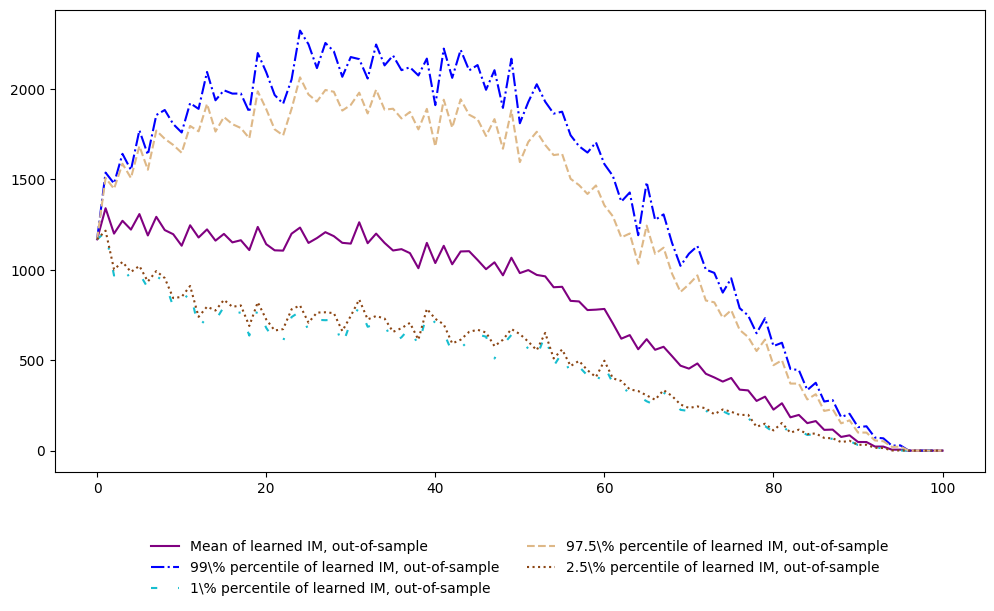

In [23]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(predicted_im_stats[0.05]['mean'], label='Mean of learned IM, out-of-sample', color='purple')
plt.plot(predicted_im_stats[0.05]['quantile', 0.99], label=r'99\% percentile of learned IM, out-of-sample', color='blue', linestyle='dashdot')
plt.plot(predicted_im_stats[0.05]['quantile', 0.01], label=r'1\% percentile of learned IM, out-of-sample', color='tab:cyan', linestyle=(0, (3, 10, 1, 10)))
plt.plot(predicted_im_stats[0.05]['quantile', 0.975], label=r'97.5\% percentile of learned IM, out-of-sample', color='burlywood', linestyle='dashed')
plt.plot(predicted_im_stats[0.05]['quantile', 0.025], label=r'2.5\% percentile of learned IM, out-of-sample', color='saddlebrown', linestyle='dotted')

# uncomment the following lines if you're including the Nested MC estimator in the plot
# plt.plot(nested_timesteps, nested_im_stats['mean'], marker='s', linestyle='None', label='Mean of Nested Monte-Carlo IM, out-of-sample', color='black')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.975], marker='^', linestyle='None', label=r'97.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='orange')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.025], marker='v', linestyle='None', label=r'2.5\% percentile of Nested Monte-Carlo IM, out-of-sample', color='gray')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.99], marker='x', linestyle='None', label=r'99\% percentile of Nested Monte-Carlo IM, out-of-sample', color='red')
# plt.plot(nested_timesteps, nested_im_stats['quantile', 0.01], marker='+', linestyle='None', label=r'1\% percentile of Nested Monte-Carlo IM, out-of-sample', color='green')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False);